In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
import pickle
from pathlib import Path

import yaml
from transformers import set_seed

from anonymization.gpt2_generation import GPT2GenerationAnonymization
from mask.util import convert_masked_docs_to_segments_set
from models.gpt2_model import PretrainedGPT2TextInfilling
from utils.infill_metrics import Statistics
from utils.log_reader import TensorBoardReader
from datasets.ner_dataset import get_ner_dataset
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
mask_config = yaml.load(open("configs/ngram_mask_config.yaml", 'r'), Loader=yaml.Loader)
roc_stories_data_config = yaml.load(open("configs/roc_stories_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Anonymization config initialisation
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Инициализация алгоритма генерации искусственных сущностей с помощью GPT2
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

### Графики обучения модели для заполнения пропусков

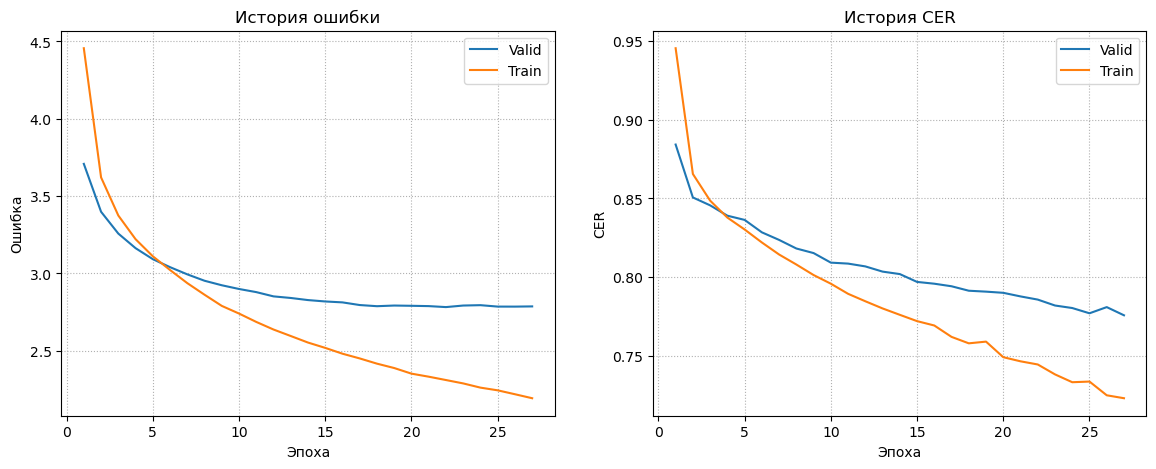

In [7]:
model_reader.plot_text_infill_tensorboard_graphics()

#### Проверка заполнения пропусков на случайным образом замаскированных текстах (roc stories)

In [8]:
path_to_data = roc_stories_data_config["validate_data_path"]
split = "valid"
if Path(path_to_data).suffix != '.pkl':
    path_to_data = str(Path(path_to_data).parent / Path(f'{Path(path_to_data).stem}_{split}.pkl'))
    
# категории сущностей в формате [список категорий отрезков в документе, ...]; исходный текст в формате [список отрезков в документе, ...]
with open(path_to_data, 'rb') as f:
    # [(текст документа, список наборов масок для него: [[(тип, сдвиг, длина), ...], ...]), ...]
    infill_dataset = pickle.load(f)
    categories_list, source_texts = convert_masked_docs_to_segments_set(infill_dataset)

In [9]:
infill_stats = Statistics(anonymization, categories_list[:3000], categories_list[:3000], source_texts[:3000], is_uncased=True)

Start data tokenization


100%|██████████| 78/78 [01:25<00:00,  1.10s/it]


In [10]:
indexes = infill_stats.random_examples_indexes(30)
infill_stats.print_examples_by_indexes(indexes[-5:])

_____ Record 1149 _____
| Labels:           | O                                         | ID     | O                                           | DATE               | O            | LOCATION           | O                             | DATE             | O                    | LOCATION |
| Source text:      | Kelly hasn't left her apartment in years. | I went | up to her place today to say hello. I could | tell she was       | reluctant to | let me in          | . We talked for a while about | how she's doing. | Kelly is agoraphobic | .        |
| Substituted text: | Kelly hasn't left her apartment in years. | she is | up to her place today to say hello. I could | not find her       | reluctant to | go                 | . We talked for a while about | it.              | Kelly is agoraphobic | and      |
| CER               |                                           | 1.0    |                                             | 0.9166666865348816 |              | 0.8888888955116272 |          

#### Проверка заполнения пропусков в примерах с личной информацией (i2b2_2006)

In [11]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], device='cpu', **i2b2_2014_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [12]:
path = str(Path(i2b2_2014_data_config["validate_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [13]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


100%|██████████| 181/181 [04:37<00:00,  1.53s/it]


In [14]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:])

_____ Record 429 _____
| Labels:           | O            | DATEYEAR           | O                                                   | DATEYEAR          | O                                                                                                              | DATEYEAR | O                   | DATEYEAR | O                                                                                                                        | DATEYEAR   | O                                                                                                                                                                                               | DATEYEAR           | O                                                                                        | HOSPITAL | O                                                                                                                                                                                                                                          